In [27]:
import pandas as pd 
import numpy as np 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping


In [28]:
#1. Đọc dữ liệu
train_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\train.csv", parse_dates=['InvoiceDate'])
val_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\valid.csv", parse_dates=['InvoiceDate'])
test_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\test.csv", parse_dates=['InvoiceDate'])

In [30]:
#2. Chuẩn bị dữ liệu 
def preprocess(df):
    df = df.copy()
    df['OrderTotal'] = (df['Quantity'] * df['UnitPrice'] * (1 - df['Discount']) + df['ShippingCost'])
    
    # Tổng doanh thu theo ngày
    df = df[['InvoiceDate', 'OrderTotal']]
    df = df.set_index('InvoiceDate').resample('D').sum().reset_index()
    
    # Feature thời gian
    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['month'] = df['InvoiceDate'].dt.month
    df['day'] = df['InvoiceDate'].dt.day
    df['year'] = df['InvoiceDate'].dt.year

    # Lag features
    df['lag1'] = df['OrderTotal'].shift(1)
    df['lag7'] = df['OrderTotal'].shift(7)
    df['lag14'] = df['OrderTotal'].shift(14)

    # Rolling features
    df['rolling_mean_7'] = df['OrderTotal'].rolling(window=7).mean()
    df['rolling_std_7'] = df['OrderTotal'].rolling(window=7).std()
    df.dropna(inplace=True)
    return df

train = preprocess(train_df)
valid = preprocess(val_df)
test = preprocess(test_df)

features = ['dayofweek', 'is_weekend', 'month', 'day', 'year',
            'lag1', 'lag7', 'lag14', 'rolling_mean_7', 'rolling_std_7']


In [31]:
# 3. Tạo tập dữ liệu huấn luyện & kiểm thử
X_train, y_train = train[features], train['OrderTotal']
X_valid, y_valid = valid[features], valid['OrderTotal']
X_test, y_test   = test[features], test['OrderTotal']

In [32]:
import xgboost as xgb
from xgboost.callback import EarlyStopping

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, 'validation')],
    callbacks=[EarlyStopping(rounds=20, save_best=True)],
    verbose_eval=True
)


[0]	validation-rmse:4454.97262
[1]	validation-rmse:4428.90839
[2]	validation-rmse:4410.56734
[3]	validation-rmse:4388.20161
[4]	validation-rmse:4372.78319
[5]	validation-rmse:4370.36900
[6]	validation-rmse:4379.23385
[7]	validation-rmse:4357.86712
[8]	validation-rmse:4333.22290
[9]	validation-rmse:4321.61449
[10]	validation-rmse:4296.91735
[11]	validation-rmse:4292.24445
[12]	validation-rmse:4279.54114
[13]	validation-rmse:4271.18911
[14]	validation-rmse:4261.45150
[15]	validation-rmse:4258.87438
[16]	validation-rmse:4247.79962
[17]	validation-rmse:4242.08187
[18]	validation-rmse:4235.93213
[19]	validation-rmse:4233.75309
[20]	validation-rmse:4230.31208
[21]	validation-rmse:4223.67289
[22]	validation-rmse:4215.66360
[23]	validation-rmse:4215.43431
[24]	validation-rmse:4200.15473
[25]	validation-rmse:4195.56449
[26]	validation-rmse:4191.73342
[27]	validation-rmse:4195.46238
[28]	validation-rmse:4194.28639
[29]	validation-rmse:4194.81505
[30]	validation-rmse:4198.40655
[31]	validation-rm

In [38]:
# 5. Dự đoán
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [39]:
# 6. Đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"R2 Score: {r2:.4f}")

MAE: 6,535.94
MSE: 83,637,768.29
R2 Score: -0.0082


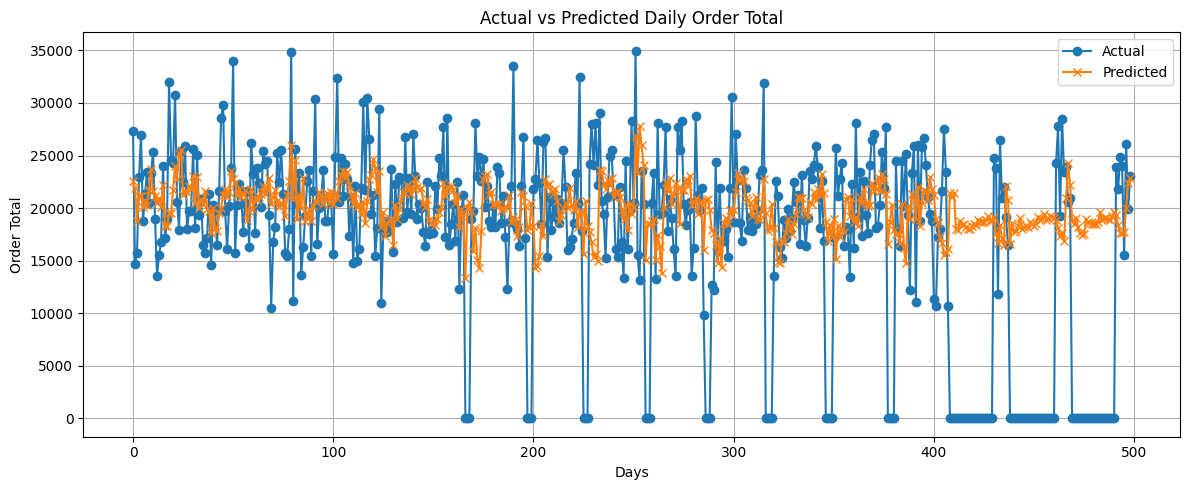

In [40]:
# 7. Trực quan hóa
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Daily Order Total')
plt.xlabel('Days')
plt.ylabel('Order Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
